In [1]:
import subprocess as sub
import sys
import ads
import re
import json
import pandas as pd
import ogr
from matplotlib import pylab
from paper_class import Paper
from feature_class import Feature
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# routine to read information from json file
# creates a Feature instance with extracted data
def feature_extract(obj):
    if '__type__' in obj and obj['__type__'] == 'Feature':
        return Feature(obj['name'], obj['id'], obj['polygon_coordinates'], obj['publications'])
    return Feature("None", 0, "None", "None")

In [3]:
# routine to parse json file and fetch definition of each feature
def parse_json_stream(text):
    list_idx = [m.start() for m in re.finditer('}\n', text)]
    list_objs = []
    last_index = 0
    for index in list_idx:
        new_feature = json.loads(text[last_index:index+2], object_hook=feature_extract)
        if (new_feature.name == "None"):
            break
        list_objs += [new_feature]
        last_index = index+2
    return list_objs

In [4]:
# code is taken from jupyter notebook 
# https://github.com/epn-vespa/vespamap17-hackathon/blob/master/vespa-mapping-jupyter-samp/SendName_to_IAUnomenclature_findPolygon_hacky.ipynb
def draw_feature_contour(feature):
    geomOGR = ogr.CreateGeometryFromWkt(feature.pcoord)
    
    figsize(6,6)
    
    coords = json.loads(geomOGR.ExportToJson())['coordinates'][0]
    print(coords)
    x = [i for i,j in coords[0]]
    y = [j for i,j in coords[0]]

    plot(x, y, 'b')
    pylab.xlabel('Longitude')
    pylab.ylabel('Latitude')
    pylab.title('Feature : ' + feature.name)
    grid()

In [5]:
# To create a database with features and their topological structure
# One needs to create a csv file with 
# https://planetarynames.wr.usgs.gov/nomenclature/AdvancedSearch
# and pass it to the database_creation script
# IMPORTANT: feature ID and feature name should be present in csv file

In [6]:
script_name = "database_merged.py"
csv_file_name = "Mars_mini.csv"
output_file_name = "features.json"
try:
    ret = sub.call(' '.join(["python", script_name, csv_file_name, output_file_name]), shell = True)
    if (ret != 0):
        print("Child returned", ret, file=sys.stderr)
except OSError as e:
    print("Execution failed: ", e, file=sys.stderr)

In [7]:
# now database is built and we want to provide speific queries to ADS
keyword = ["landing site"]
toponym = "Abalos Colles"
years = range(2003, 2017)
query_list = ["", "", ""]

if (toponym):
    query_list[0] = toponym

if (keyword):
    for idx in range(len(keyword) - 1):
        query_list[1] += "author:" + keyword[idx] + " OR "
    query_list[1] += "author:" + keyword[-1]
        
if (years):
    query_list[2] = "year:[" + str(years.start) + " TO " + str(years.stop) + "]" 

query = ' AND '.join(filter(None, query_list))

In [8]:
if (not query):
    raise RuntimeError("Empty query is not allowed!")
print(query)

Abalos Colles AND author:landing site AND year:[2003 TO 2017]


In [9]:
#performing a query to ADS API
example_results = []
try:
    example_results = list(ads.SearchQuery(q=query, fl=['title', 'author', 'year', 'pub', 'bibcode']))
except (ads.exceptions.APIResponseError, ads.exceptions.SolrResponseParseError) as e:
    "Error: {}".format(e)

In [10]:
# representing results with custom Paper class
results_new = []
for paper in example_results:
    results_new.append(Paper(paper.title[0], paper.author, paper.year, paper.pub, paper.bibcode))

In [11]:
# dig the database for the requested toponym
with open(output_file_name) as fin:
    features = parse_json_stream(fin.read())

Abalos Colles is found in the database!
[[[291.57163429260254, 74.97826194763184], [291.13057136535645, 74.8109302520752], [290.57140159606934, 74.8525562286377], [284.5605068206787, 76.16095542907715], [284.5394763946533, 76.43600654602051], [284.74025535583496, 77.1826000213623], [284.81204414367676, 78.65801429748535], [284.790002822876, 78.6591625213623], [285.07346534729004, 78.78381538391113], [293.35122871398926, 77.87516212463379], [293.3949947357178, 77.76282691955566], [291.57163429260254, 74.97826194763184]]]


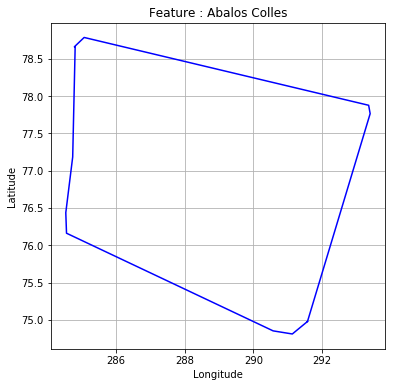

In [12]:
# if the entry exists - draw the toponym as a polygon
for feature in features:
    if (toponym == feature.name):
        print(toponym + " is found in the database!")
        draw_feature_contour(feature)
        break
    else:
        print("Cannot find in the database!")

In [13]:
# create pandas table
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame([paper.to_dict() for paper in results_new])